<a href="https://colab.research.google.com/github/Kewal1903/ML-Quest-codes/blob/main/Hackathon(RFC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


**Team Name :- The Syndicate**


---


**Team Members:- Shasmeet Shinde, Kewal Thacker, Vishnu Pai**


---


**Problem Statement :- Identifying Fake Job Listings: Build a classification model to determine the legitimacy of job postings.**


---



Importing required libraries.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

Loading the dataset

In [ ]:
df = pd.read_csv("/content/job_train.csv")
df.dropna(inplace = True)
df

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,fraudulent
0,Architect (Middleware - MQ) - Kuwait,"KW, KU,","On behalf of our client, a well known multinat...",-Working technical knowledge of IT systems and...,0,1,0,0
1,Interviewing Now for Sales Rep Positions -- wi...,"US, TX, Corpus Christi","We are Argenta Field Solutions, a rapidly expa...",#NAME?,0,1,0,0
2,Process Controls Staff Engineer - Foxboro I/A ...,"US, TX, USA Southwest",Experienced Process Controls Staff Engineer is...,At least 10 years of degreed professional expe...,0,0,0,0
3,Experienced Telemarketer Wanted - Digital Solu...,"AU, NSW,",If you have a passion for people and love to s...,"Responsibilities - Prospecting, following up a...",0,1,0,0
4,Senior Network Engineer,"GB, ENG, London",As the successful Senior Network Engineer you ...,Essential skills:•Juniper switching/routing/se...,0,1,0,0
...,...,...,...,...,...,...,...,...
8934,Data Manager--Fixed Income,"US, NY, New York","The salary is open, DOE. This role manages 4 D...",Required Skills:BA/BS in Business Administrati...,0,0,0,0
8935,Financial Analyst,"GR, I, Paiania","Financial analysis, reporting and review of de...",Postgraduate degree required. Economics or Fin...,0,1,1,0
8936,Customer Service Associate - Part Time,"CA, ON, Peterborough",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,0,1,0,0
8937,Sales Manager,"UA, 61, Ternopil","Responsibilitiesactive sales, realization of c...",Main requirementsexperience with Sales (2+ yea...,0,0,1,0


Preprocessing the text fields: Checking for validity of words, removing extra spaces and punctuations, simplifying words to their word roots using WordNetLemmatizer. This makes it easier to identify similar entires in text fields and can help in encoding them later.

In [ ]:
import re
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
  text = text.lower()
  text = re.sub(r"\W", " ",text)
  text = re.sub(r"\s", " " , text)
  stop_words = set(stopwords.words("english"))
  lemmatizer = WordNetLemmatizer()
  words = text.split()
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
  return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df["title"] = df["title"].apply(preprocess_text)
df["location"] = df["location"].apply(preprocess_text)
df["description"] = df["description"].apply(preprocess_text)
df["requirements"] = df["requirements"].apply(preprocess_text)
df

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,fraudulent
0,architect middleware mq kuwait,kw ku,behalf client well known multinational retail ...,working technical knowledge system fundamental...,0,1,0,0
1,interviewing sale rep position management trai...,u tx corpus christi,argenta field solution rapidly expanding award...,name,0,1,0,0
2,process control staff engineer foxboro tricone...,u tx usa southwest,experienced process control staff engineer req...,least 10 year degreed professional experience ...,0,0,0,0
3,experienced telemarketer wanted digital solution,au nsw,passion people love sell telephone role overvi...,responsibility prospecting following lead gene...,0,1,0,0
4,senior network engineer,gb eng london,successful senior network engineer must jncia ...,essential skill juniper switching routing secu...,0,1,0,0
...,...,...,...,...,...,...,...,...
8934,data manager fixed income,u ny new york,salary open doe role manages 4 data analyst in...,required skill ba b business administration fi...,0,0,0,0
8935,financial analyst,gr paiania,financial analysis reporting review department...,postgraduate degree required economics finance...,0,1,1,0
8936,customer service associate part time,ca peterborough,customer service associate based peterborough ...,minimum requirement minimum 6 month customer s...,0,1,0,0
8937,sale manager,ua 61 ternopil,responsibilitiesactive sale realization compan...,main requirementsexperience sale 2 year fluent...,0,0,1,0


Encoding title and location fields in order to associate different listings having same title or location.

In [ ]:
label_encoder = LabelEncoder()
df["title"] = label_encoder.fit_transform(df["title"])
df["location"] = label_encoder.fit_transform(df["location"])
df

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,fraudulent
0,238,527,behalf client well known multinational retail ...,working technical knowledge system fundamental...,0,1,0,0
1,2137,1528,argenta field solution rapidly expanding award...,name,0,1,0,0
2,3184,1570,experienced process control staff engineer req...,least 10 year degreed professional experience ...,0,0,0,0
3,1431,29,passion people love sell telephone role overvi...,responsibility prospecting following lead gene...,0,1,0,0
4,3931,244,successful senior network engineer must jncia ...,essential skill juniper switching routing secu...,0,1,0,0
...,...,...,...,...,...,...,...,...
8934,994,1339,salary open doe role manages 4 data analyst in...,required skill ba b business administration fi...,0,0,0,0
8935,1486,469,financial analysis reporting review department...,postgraduate degree required economics finance...,0,1,1,0
8936,898,92,customer service associate based peterborough ...,minimum requirement minimum 6 month customer s...,0,1,0,0
8937,3629,1682,responsibilitiesactive sale realization compan...,main requirementsexperience sale 2 year fluent...,0,0,1,0


Visualizing relations between certain parameters and the legitimacy of the job postings.

In [ ]:
crosstab1 = pd.crosstab(df["fraudulent"], df["has_questions"])
crosstab1.index = ["Not Fraudulent", "Fraudulent"]
crosstab1.columns = ["No Questions", "Has Questions"]
crosstab1

,No Questions,Has Questions
Not Fraudulent,3255,3901
Fraudulent,254,123


In [ ]:
crosstab2 = pd.crosstab(df["fraudulent"], df["has_company_logo"])
crosstab2.index = ["Not Fraudulent", "Fraudulent"]
crosstab2.columns = ["No Logo", "Has Logo"]
crosstab2

,No Logo,Has Logo
Not Fraudulent,979,6177
Fraudulent,223,154


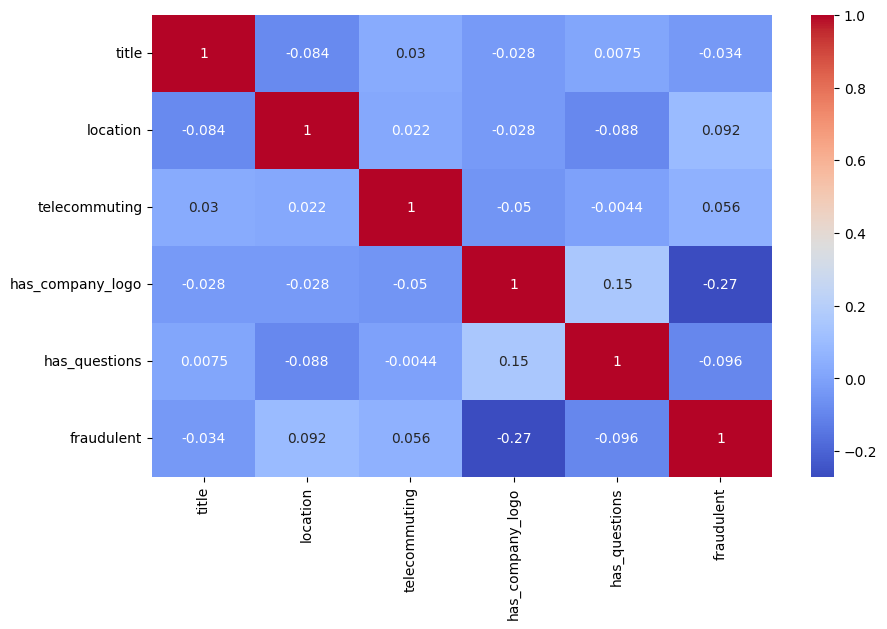

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only = True), annot = True, cmap = "coolwarm")
plt.show()

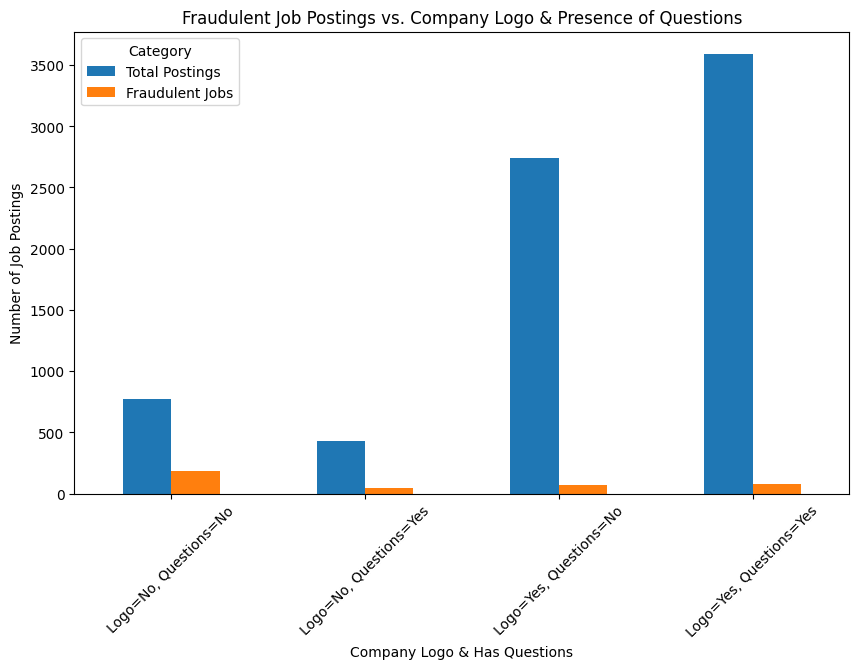

In [ ]:
grouped_data = df.groupby(["has_company_logo", "has_questions", "fraudulent"])["title"].count().unstack().fillna(0)
plot_data = pd.DataFrame({
    "Total Postings": grouped_data.sum(axis=1),
    "Fraudulent Jobs": grouped_data[1]
})
plot_data.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Company Logo & Has Questions")
plt.ylabel("Number of Job Postings")
plt.title("Fraudulent Job Postings vs. Company Logo & Presence of Questions")
plt.xticks(ticks=[0, 1, 2, 3], labels=[
    "Logo=No, Questions=No",
    "Logo=No, Questions=Yes",
    "Logo=Yes, Questions=No",
    "Logo=Yes, Questions=Yes"
], rotation=45)

plt.legend(title="Category")
plt.show()

Identifying feature variables and target variable

In [ ]:
X = df[["description", "requirements", "telecommuting","has_company_logo","has_questions"]]
y = df["fraudulent"]

Data transformation and processing to optimize it for analysis and classification.

In [ ]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_description = tfidf.fit_transform(df["description"]).toarray()
X_requirements = tfidf.fit_transform(df["requirements"]).toarray()
X = np.hstack((X_description, X_requirements, df[["telecommuting", "has_company_logo", "has_questions"]].values))

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Performing PCA (Principal component analysis) to track explained variance of features in order to identify the information given by each feature and discard the features giving less information.

In [ ]:
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
print(f"Shape of X before PCA: {X_scaled.shape}")
print(f"Shape of X after PCA: {X_pca.shape}")

Shape of X before PCA: (7533, 20003)
Shape of X after PCA: (7533, 3482)


In [ ]:
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by each component: {explained_variance}")

Explained Variance by each component: [1.09224299e-02 9.20483678e-03 8.93136832e-03 ... 7.54871104e-05
 7.54841698e-05 7.54450390e-05]


In [ ]:
cumulative_variance = np.cumsum(explained_variance)
print(f"Cumulative Variance explained by components: {cumulative_variance}")

Cumulative Variance explained by components: [0.01092243 0.02012727 0.02905864 ... 0.89989114 0.89996663 0.90004207]


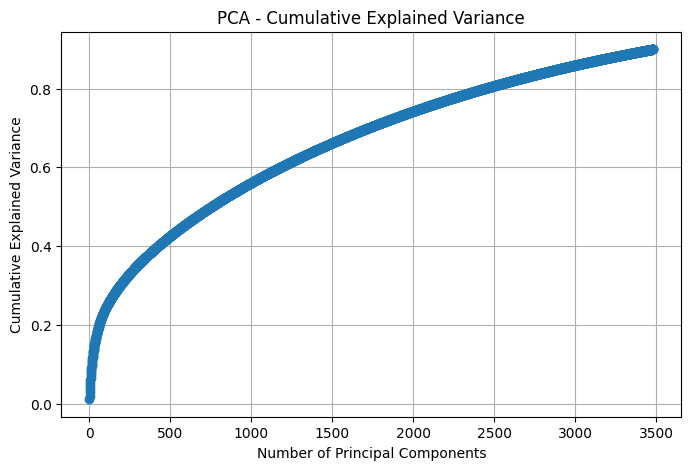

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.show()

Using SMOTE to balance the datasets by accounting for lesser represented classes.

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, df["fraudulent"])

Splitting the dataset into training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Using grid search algorithm to find optimal hyperparameters and then using Random Forest Classifier to classify the jobs as fraudulent or not.

In [ ]:
param_dist = {
    "n_estimators": [100, 150],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

model = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=10, cv=3, scoring="accuracy", n_jobs=-1, random_state=42, verbose=2)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 150]},
                   random_state=42, scoring='accuracy', verbose=2)

Identifying best model out of different trials done during grid search, and then evaluating it using evaluation metrics such as accuracy, area under curve (AUC) score and classification report.

In [ ]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Accuracy: 0.9968564442892072
ROC-AUC Score: 0.9968624034979845
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1428
           1       1.00      0.99      1.00      1435

    accuracy                           1.00      2863
   macro avg       1.00      1.00      1.00      2863
weighted avg       1.00      1.00      1.00      2863



Testing accuracy during the cross validation process.

In [ ]:
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring="accuracy")
print(f"Cross-Validation Accuracy: {np.mean(cv_scores)}")

Cross-Validation Accuracy: 0.9973450513100834


Hence, we can see that on an average the model can make predictions with upto 99.73% accuracy.